# Final Report

This notebook retrieves analysis results from SQL Server and generates simple reports with visualizations.

## What This Notebook Does:
1. Connects to SQL Server database
2. Retrieves analysis results using SQL queries
3. Generates simple plots using Pandas
4. Saves final reports as CSV files

# Import Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Connect to SQL Server

In [6]:
from sqlalchemy import create_engine
from urllib.parse import quote_plus

SERVER = r"GEMY"
DATABASE = "RetailDB"
ODBC_DRIVER = "ODBC Driver 17 for SQL Server"

conn_str = (
    f"DRIVER={{{ODBC_DRIVER}}};"
    f"SERVER={SERVER};"
    f"DATABASE={DATABASE};"
    "Trusted_Connection=yes;"
)

engine = create_engine(
    "mssql+pyodbc:///?odbc_connect=%s" % quote_plus(conn_str),
    fast_executemany=True
)


# Retrieve Analysis DataFrames

### Query 1 - Top 10 Products

In [7]:
query1 = """
select top 10
    p.product_id,
    p.product_name,
    sum(oi.quantity) as total_quantity_sold
from orderitems as oi
join products as p on oi.product_id = p.product_id
group by p.product_id, p.product_name
order by total_quantity_sold desc
"""
df_top_products = pd.read_sql(query1, engine)

In [8]:
df_top_products.head()

,product_id,product_name,total_quantity_sold
0,6,Surly Ice Cream Truck Frameset - 2016,167
1,13,Electra Cruiser 1 (24-Inch) - 2016,157
2,16,Electra Townie Original 7D EQ - 2016,154
3,23,Electra Girl's Hawaii 1 (20-inch) - 2015/2016,154
4,7,Trek Slash 8 27.5 - 2016,152


### Query 2 - Top 5 Customers

In [10]:
query2 = """
select top 5
    c.customer_id,
    c.first_name + ' ' + c.last_name as customer_name,
    sum(oi.quantity * oi.list_price) as total_spending
from orders as o
join customers as c on o.customer_id = c.customer_id
join orderitems as oi on o.order_id = oi.order_id
group by c.customer_id, c.first_name, c.last_name
order by total_spending desc
"""
df_top_customers = pd.read_sql(query2, engine)

In [11]:
df_top_customers.head()

,customer_id,customer_name,total_spending
0,19,Lizzette Stein,511236.93
1,730,Andria Rivers,461192.00
2,1226,Qiana Jackson,227392.00
3,1002,Cami Williamson,133397.00
4,222,Anya Contreras,100748.99


### Query 3 - Revenue per Store

In [12]:
query3 = """
select
    s.store_id,
    s.store_name,
    sum(oi.quantity * oi.list_price) as total_revenue
from orders as o
join stores as s on o.store_id = s.store_id
join orderitems as oi on o.order_id = oi.order_id
group by s.store_id, s.store_name
order by total_revenue desc
"""
df_stores_revenue = pd.read_sql(query3, engine)

In [14]:
df_stores_revenue.head()

,store_id,store_name,total_revenue
0,2,Baldwin Bikes,6797085.72
1,1,Santa Cruz Bikes,1778184.89
2,3,Rowlett Bikes,1412320.86


### Query 4 - Revenue per Category

In [15]:
query4 = """
select
    c.category_id,
    c.category_name,
    sum(oi.quantity * oi.list_price) as total_revenue
from orderitems as oi
join products as p on oi.product_id = p.product_id
join categories as c on p.category_id = c.category_id
group by c.category_id, c.category_name
order by total_revenue desc
"""
df_categories_revenue = pd.read_sql(query4, engine)

In [16]:
df_categories_revenue.head()

,category_id,category_name,total_revenue
0,6,Mountain Bikes,3357664.89
1,7,Road Bikes,2105434.65
2,3,Cruisers Bicycles,1510384.24
3,5,Electric Bikes,1014796.86
4,4,Cyclocross Bicycles,795193.62


### Query 5 - Monthly Sales

In [33]:
query5 = """
select
    year(o.order_date) as year,
    month(o.order_date) as month,
    sum(oi.quantity * oi.list_price) as monthly_revenue
from orders as o
join orderitems as oi on o.order_id = oi.order_id
group by year(o.order_date), month(o.order_date)
order by year, month
"""
df_monthly_sales = pd.read_sql(query5, engine)

In [34]:
df_monthly_sales.head()

,year,month,monthly_revenue
0,2016,1,207886.38
1,2016,2,175768.10
2,2016,3,202157.14
3,2016,4,187223.55
4,2016,5,228701.13


### Save DataFrames as CSV

In [19]:
df_top_products.to_csv(r'D:\Downloads\Project\reports\top_products.csv', index=False)
df_top_customers.to_csv(r'D:\Downloads\Project\reports\top_customers.csv', index=False)
df_stores_revenue.to_csv(r'D:\Downloads\Project\reports\store_revenue.csv', index=False)
df_categories_revenue.to_csv(r'D:\Downloads\Project\reports\category_revenue.csv', index=False)
df_monthly_sales.to_csv(r'D:\Downloads\Project\reports\monthly_sales.csv', index=False)

# Set Plot Style

In [20]:
plt.style.use('classic')

### Plot 1 - Top Products Bar Chart

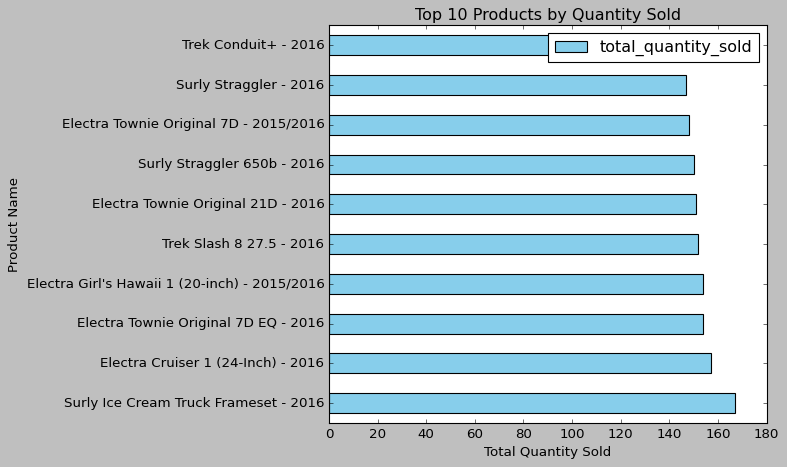

In [38]:
df_top_products.plot(
    kind='barh',
    x='product_name',
    y='total_quantity_sold',
    title='Top 10 Products by Quantity Sold',
    figsize=(10,6),
    color='skyblue'  
)

plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.tight_layout()
plt.savefig(r'D:\Downloads\Project\plots\plot_top_products.png')
plt.show()

### Plot 2 - Top Customers Horizontal Bar

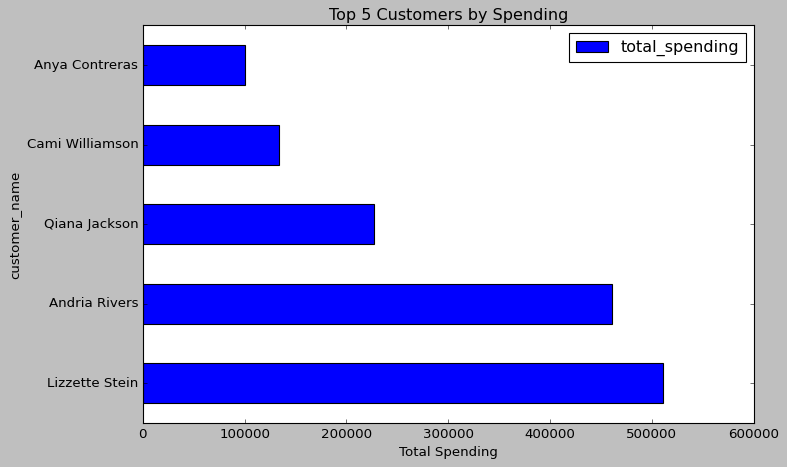

In [30]:
df_top_customers.plot(
    kind='barh',
    x='customer_name',
    y='total_spending',
    title='Top 5 Customers by Spending',
    figsize=(10,6)
)
plt.xlabel('Total Spending')
plt.tight_layout()
plt.savefig(r'D:\Downloads\Project\plots\plot_top_customers.png')
plt.show()

### Plot 3 - Store Revenue Bar Chart

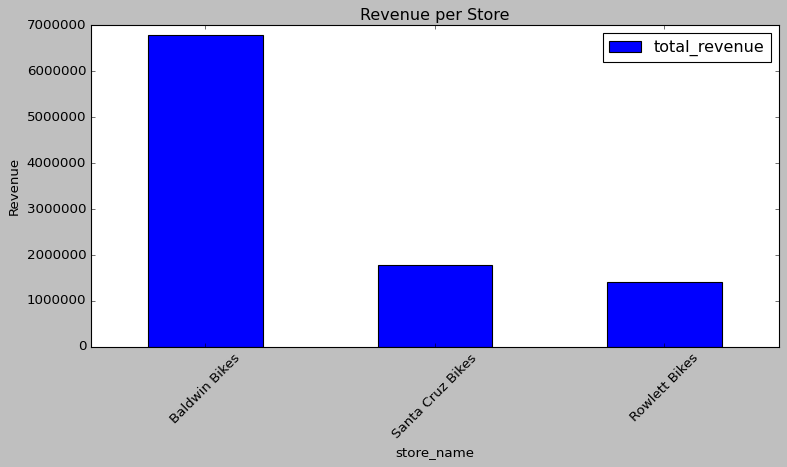

In [ ]:
df_stores_revenue.plot(
    kind='bar',
    x='store_name',
    y='total_revenue',
    title='Revenue per Store', 
    figsize=(10,6)
)
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r'D:\Downloads\Project\plots\plot_store_revenue.png')
plt.show()

### Plot 4 - Category Revenue Pie Chart

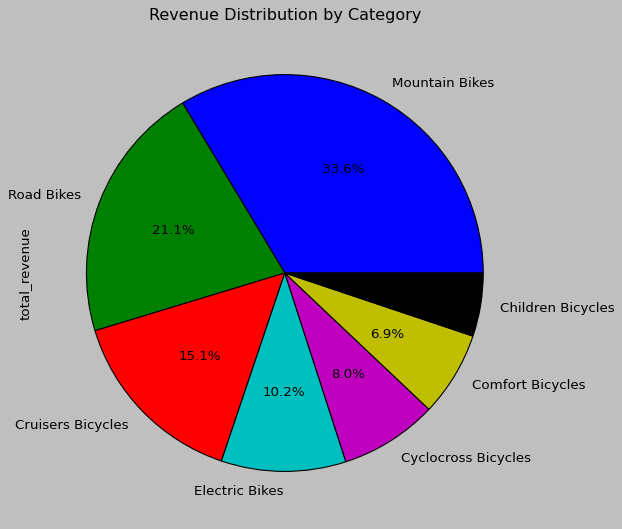

In [32]:
df_categories_revenue.plot(
    kind='pie',
    y='total_revenue',
    labels=df_categories_revenue['category_name'],
    autopct='%1.1f%%',
    title='Revenue Distribution by Category',
    figsize=(8,8),
    legend=False
)
plt.savefig(r'D:\Downloads\Project\plots\plot_category_revenue.png')
plt.show()

#### Plot 5 - Monthly Sales Line Chart

In [36]:
df_monthly_sales['year_month'] = (
    df_monthly_sales['year'].astype(str)
    + '-'
    + df_monthly_sales['month'].astype(str).str.zfill(2)
)

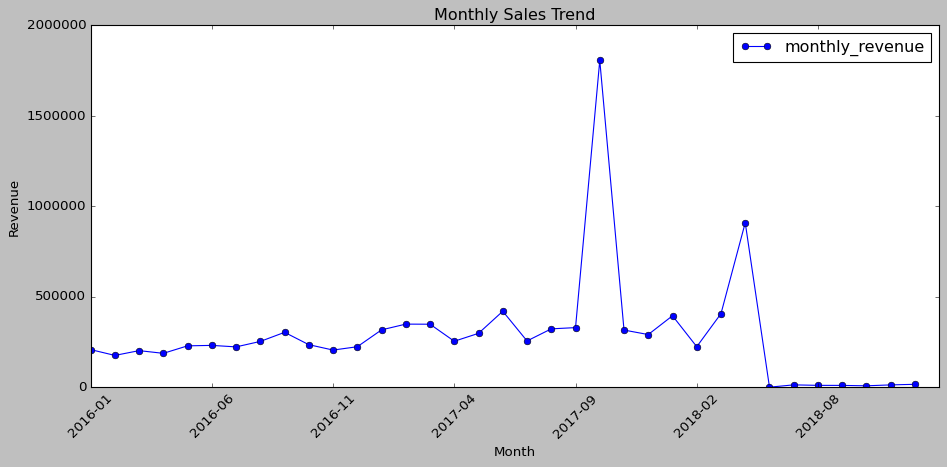

In [37]:
df_monthly_sales.plot(
    kind='line',
    x='year_month',
    y='monthly_revenue',
    title='Monthly Sales Trend',
    figsize=(12,6),
    marker='o'
)

plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r'D:\Downloads\Project\plots\plot_monthly_trend.png')
plt.show()